In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from finsde.models.sde import LatentSDE
from finsde.models.discrete_sde import DiscreteLatentSDE
from finsde.core import FinSDELightningModule
from finsde.utils.dataloader import SingleStockDataset, SingleStockDataModule

In [3]:
from pathlib import Path
import matplotlib

In [4]:
font_dir = Path("../fonts")
for font_path in font_dir.glob("*.ttf"):
    print(font_path)
    matplotlib.font_manager.fontManager.addfont(font_path)

../fonts/Arial.ttf
../fonts/Arial_Italic.ttf
../fonts/Arial_Black.ttf
../fonts/Arial_Bold.ttf
../fonts/Arial_Bold_Italic.ttf


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from omegaconf import OmegaConf
import hydra

OmegaConf.register_new_resolver("eval", eval)

In [48]:
run_dir = Path("../scripts/results/run-2025-04-17_10-04-04")
cfg_path = run_dir / "config.yaml"
cfg = OmegaConf.load(cfg_path)

In [49]:
checkpoint_type = "last"

checkpoint_dir = run_dir / "checkpoints"
if checkpoint_type == "best":
    checkpoint_path = sorted(checkpoint_dir.glob("epoch=*.ckpt"))[-1]
elif checkpoint_type == "last":
    checkpoint_path = checkpoint_dir / "last.ckpt"

In [50]:
model_cfg = cfg.model.copy()
del model_cfg._target_
kwargs = hydra.utils.instantiate(model_cfg)
pl_module = FinSDELightningModule.load_from_checkpoint(
    checkpoint_path,
    **kwargs
)

/data/user_data/fcpei/miniconda3/envs/finsde/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.


In [51]:
datamodule_cfg = cfg.datamodule.copy()
datamodule_cfg.pred_horizon = 10
datamodule = hydra.utils.instantiate(datamodule_cfg)
datamodule.setup("")

In [52]:
eval_dataset = datamodule.test_dataset

In [54]:

rng = np.random.default_rng(0)

n_traj = 5
n_samples = 50
trajs = []

with torch.no_grad():
    for j in range(n_traj):
        dataset_idx = rng.choice(len(eval_dataset.datasets))
        traj_idx = rng.choice(len(eval_dataset.datasets[dataset_idx]))
        x, y = eval_dataset.datasets[dataset_idx][traj_idx]

        x = x.unsqueeze(0)
        y = y.unsqueeze(0)

        samples = []
        for i in range(n_samples):
            y_hat = []
            x_curr = x
            for _ in range(10):
                y_curr = pl_module.predict_step(
                    batch=(x_curr.to(pl_module.device), y[:, :3, :].to(pl_module.device)),
                    batch_idx=None,
                    # n_samples=1,
                ).to(y.device)
                y_curr = y_curr.reshape((y.shape[0], 3, -1))[:, [0], :]
                x_curr = torch.cat([x_curr[:, 1:, :], y_curr], dim=1)
                y_hat.append(y_curr)
            y_hat = torch.cat(y_hat, dim=1)
            all_pred = torch.cat([x, y_hat], dim=1)

            samples.append(all_pred.cpu().numpy())
        
        traj_mean = np.mean(samples, axis=0)[0, :, 0]
        traj_std = np.std(samples, axis=0)[0, :, 0]
        true_traj = torch.cat([x[0, :, 0], y[0, :, 0]], dim=0).detach().cpu().numpy()
        trajs.append((true_traj, traj_mean, traj_std))

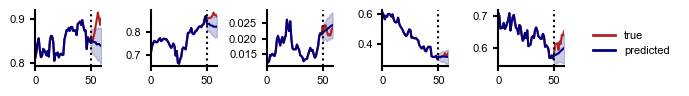

In [55]:
from matplotlib.lines import Line2D

with plt.rc_context(fname="../.matplotlibrc"):
    fig, axs = plt.subplots(1, n_traj+1, figsize=(1.2*n_traj+1, 1))
    for i, (true, mean, std) in enumerate(trajs):
        axs[i].plot(true, color="firebrick")
        axs[i].plot(mean, color="navy")
        axs[i].fill_between(np.arange(len(mean)), mean - 2 * std, mean + 2 * std, color="navy", alpha=0.2)
        axs[i].axvline(50, ymin=0, ymax=1, linestyle=":", color="black")
        axs[i].set_xlim(0, 59)
    axs[-1].axis('off')

    custom_lines = [Line2D([0], [0], color="firebrick", lw=2),
                    Line2D([0], [0], color="navy", lw=2)]
    plt.legend(custom_lines, ['true', 'predicted'], loc="lower right")
    plt.tight_layout()
    plt.savefig("temp.pdf")
    plt.show()

In [17]:
trajs[0].shape

(70, 1, 6)

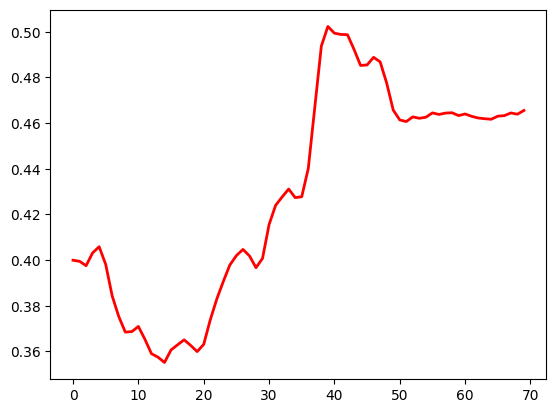

In [18]:
plt.plot(np.stack(trajs, axis=0).mean(axis=0)[:, 0, 0], color="red", linewidth=2)
